# Demonstration of wiki data segmetation

#### This notebook demonstrates that how to segment any given dataset based on the types of workload included in it.
#### This notebook also includes examples of different time series types, and how to inteprate the *characteristic scores*.

In [1]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import heapq

In [2]:
# important window definition
prediction_length = 48
context_length = 72
day = 24
week = 148
month = 720
year = 8760

### Prepare time series

In [3]:
# get the Time Series data and corresponding wiki project name
def get_ts(data_location,label_location,freq):
    df_ts = pd.read_json(data_location, lines=True)
    num_pt = min(len(df_ts.iloc[1, 1]), 100000)
    print('use first ', num_pt, ' points in a time series')
    num_ts = len(df_ts)

    time_series_wiki = []
    for k in range(num_ts):
        t0 = df_ts.iloc[k, 0]
        data = df_ts.iloc[k, 1][:num_pt]
        index = pd.DatetimeIndex(start=t0, freq=freq, periods=num_pt)
        time_series_wiki.append(pd.Series(data=data, index=index))
        
    with open(label_location) as f:
        wp_list = f.read().splitlines()  
        
    return time_series_wiki, wp_list

In [4]:
label_location = 'wp_full-20180101-20190101_get.txt'    
data_location = 'test_1year.json'
freq = 'H'

time_series_wiki, wp_list = get_ts(data_location,label_location,freq)

use first  8784  points in a time series


### DFT visualization function

In [5]:
# discrete Fourier transform with FFT
def discrete_ft(x,window):
    # important variables are written explicitly
    y = x.values # signal

    Fs = 1 # sampling rate, in our case let's use 1 Hour^-1
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range

    # we only keep the positive frequency up to the Nyquist = 1/2*Fs
    cycle = frq[range(1,int(n/2))] * window # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(1, int(n/2))] # again, spectrum corrresponding to the positive half

    fig, ax = plt.subplots(2, 1, figsize = (10,5))
    ax[0].plot(x)
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('network traffic')
    ax[1].plot(cycle,abs(Y),'r') # plotting the spectrum
    ax[1].set_xlabel('cycles per '+str(window)+' hours')
    ax[1].set_ylabel('network frequency spectrum')

### The time series characterization tool based on discrete Fourier transform.

In [6]:
# time series characterization with FFT
import heapq
def characterize_ts(ts, window):
    y = ts.values  # signal
    Fs = 1  # sampling rate, in our case let's use 1 Hour^-1
    n = len(y)  # length of the signal
    k = np.arange(n)
    T = n / Fs
    frq = k / T  # two sides frequency range
    # We only keep the positive frequency up to the Nyquist = 1/(2*dT), dT = sampling interval.
    cycle = frq[range(1, int(n / 2))] * window  # one side frequency range

    Y = np.fft.fft(y) / n  # fft computing and normalization
    Y = Y[range(1, int(n / 2))]  # again, spectrum corrresponding to the positive half
    yabs = np.abs(Y)

    # Locate the largest 15 peaks, use them to characterise the time series.
    indx = heapq.nlargest(15, range(len(yabs)), yabs.__getitem__)
    amp = heapq.nlargest(15, yabs)

    mean = yabs.mean()
    std = yabs.std()
    cyc_hday = 2.0
    cyc_day = cyc_hday / 2.0
    cyc_week = cyc_day / 7.0
    cyc_month = cyc_day / 30.0

    comp = lambda a, b: np.abs(a / b - 1) < 0.05
    ts_type = ['trend', 'hDay', 'Day', 'Week', 'Month', 'DayImpulse', 'spike']
    report_list = [0] * 8
    for counter, value in enumerate(indx):
        # Here we define a peak in frequency domain.
        if amp[counter] > (mean + 3 * std):
            amp_norm = (amp[counter] - mean) / std
            if cycle[value] < 0.01:
                # Trend (increasing, decreasing, gaussian pulse).
                report_list[0] = max(amp_norm, report_list[0])
            elif comp(cycle[value], cyc_hday):
                report_list[1] = max(amp_norm, report_list[1])
            elif comp(cycle[value], cyc_day):
                report_list[2] = max(amp_norm, report_list[2])
            elif comp(cycle[value], cyc_week):
                report_list[3] = max(amp_norm, report_list[3])
            elif comp(cycle[value], cyc_month):
                report_list[4] = max(amp_norm, report_list[4])

    if sum(report_list[:5]) > 0:
        index = report_list[:5].index(max(report_list[:5]))
        report_list[5] = ts_type[index]
    else:
        report_list[5] = ts_type[-1]

    # Add a subcategory: a special day seasonality that has a periodic impulse shape.
    if report_list[5] == 'hDay' or report_list[5] == 'Day':
        harmonic = set(range(12))
        all_peak = set()
        for counter, value in enumerate(indx):
            if amp[counter] > (mean + 3 * std):
                all_peak.add(int(round(cycle[value])))
        if len(harmonic.intersection(all_peak)) > 10:
            report_list[5] = ts_type[-2]

    report_list[-2] = y.mean()
    report_list[-1] = y.std()
    return report_list

### Convert the report list to Pandas dataframe for easier speculation.

In [7]:
character_list = []
for item in time_series_wiki:
    character_list.append(characterize_ts(item,day))

with open(data_location[:-5] + '_stats.txt', 'w') as f:
    for item in character_list:
        for info in item:
            f.write("%s\t" % info)
        f.write("\n")    

In [8]:
df = pd.DataFrame(character_list,wp_list, 
                  columns = ['trend_score', 'hday_score', 'day_score','week_score', 'month_score','character','mean','std'])

In [9]:
df.reset_index(level=0, inplace=True)
df.rename(columns={'index':'project'}, inplace = True)

In [10]:
# now we have a workable dataframe
df.head()

,project,trend_score,hday_score,day_score,week_score,month_score,character,mean,std
0,aa.wikipedia.org,11.418841,0.000000,0.000000,0.0,7.875303,trend,27.925888,95.229821
1,aa.wikibooks.org,13.385391,0.000000,0.000000,0.0,12.325506,trend,20.088342,122.588757
2,aa.wiktionary.org,9.347850,11.925226,11.978428,0.0,0.000000,DayImpulse,5.751138,15.827372
3,ab.wikipedia.org,14.519234,0.000000,10.684804,0.0,0.000000,trend,202.561931,303.248786
4,ab.wiktionary.org,8.253239,15.463952,14.215497,0.0,4.614637,DayImpulse,6.962887,20.878857


## Given the data set, we can examine what's in there:
1. a break-down of different types of time series -- by *type*, I mean the strongest characteristic of given time series: time series can show <b>multiple characteristics</b>, e.g. periodic + trend.
2. We can have detailed look of the score distributions for each type of time series, regardless of what the *type* is.
3. The characteristic score is <b>normalized</b>: this means we can compare within one time series, and we can compare across different time series.

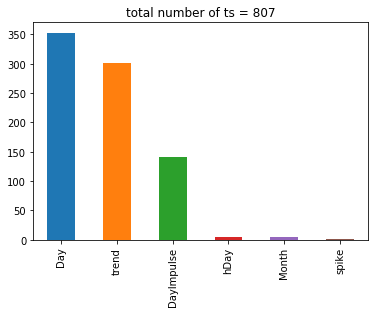

In [11]:
df['character'].value_counts().plot(kind='bar', title = 'total number of ts = {}'.format(len(df)))

### Examine how the *trend* characteristic distributes in the dataset.

12.632097872475471


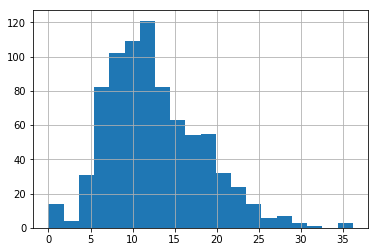

In [12]:
print(df['trend_score'].mean())
df['trend_score'].hist(bins = 20)

### Examine how the *Half day seasonality* characteristic distributes in the dataset.
- Most of the time series don't have such characteristic.

9.561388292224471


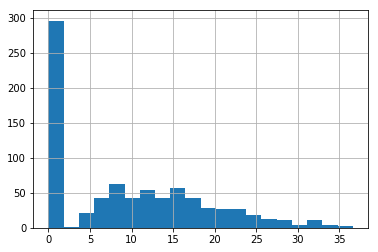

In [13]:
print(df['hday_score'].mean())
df['hday_score'].hist(bins = 20)

### Examine how the *Day seasonality* characteristic distributes in the dataset.
- Most time series show certain extent of day seasonality.

20.87345900410888


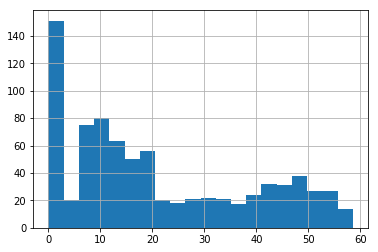

In [14]:
print(df['day_score'].mean())
df['day_score'].hist(bins = 20)

### Examine how the *week* characteristic distributes in the dataset.
- Most time series don't show any weekly seasonality. A small portion of them show a bit of this characteristic.

3.2110487819094384


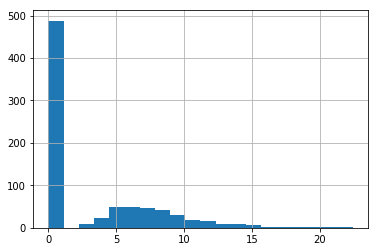

In [15]:
print(df['week_score'].mean())
df['week_score'].hist(bins = 20)

### Examine how the *week* characteristic distributes in the dataset.
- Again, most time series don't show any weekly seasonality. A very small portion of them show a bit of this characteristic.

1.4328699110415941


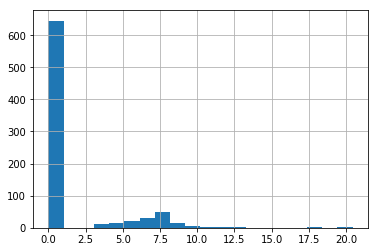

In [16]:
print(df['month_score'].mean())
df['month_score'].hist(bins = 20)

### Examine scale (mean amplitude) of the time series.
- Note that we have logscale for x-axis. The distribution of the amplitude is skewed, mostly small scale time series with fewer large scale (heavy web traffic) ones. 

mean of mean over all time series..(ugh weird wording)  26702.176045271026  max val  10508012.864184882  min val  0.23258196721311475


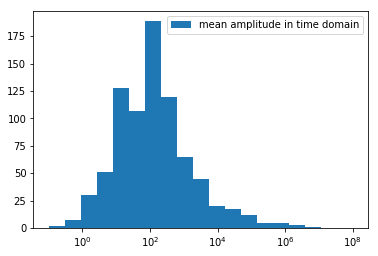

In [17]:
print('mean of mean over all time series..(ugh weird wording) ', 
      df['mean'].mean(), ' max val ', df['mean'].max(), ' min val ', df['mean'].min())
plt.hist(df['mean'], bins=np.logspace(np.log10(0.1),np.log10(100000000), 20), label = 'mean amplitude in time domain')
plt.gca().set_xscale("log")
plt.legend()

## Now we look at a few examples of *Day* seasonality time series:

In [18]:
# check a few Day seasonality time series
df.loc[df['character'] == 'Day', :].sort_values(by = 'day_score', ascending = False).head()

,project,trend_score,hday_score,day_score,week_score,month_score,character,mean,std
583,ru.wikipedia.org,12.002549,22.920719,58.522701,4.661875,0.0,Day,1.177687e+06,491780.690852
555,pt.wikipedia.org,9.363315,20.517322,58.304491,8.336847,0.0,Day,4.699367e+05,220754.292696
187,es.wikipedia.org,9.666588,13.734932,58.078266,12.137770,0.0,Day,1.412229e+06,629038.816024
226,fr.wikipedia.org,7.503050,22.948361,57.800319,4.563756,0.0,Day,9.438559e+05,449531.722369
228,fr.wiktionary.org,9.309148,13.478761,57.671281,8.689841,0.0,Day,2.676646e+04,14387.944345


We can see a clear daily-periodic behavior in the following example. We can also see a hint of the weekly periodity and half-day periodity (the small dent on daily peaks). These are also reflected in the week-score and half-day score.

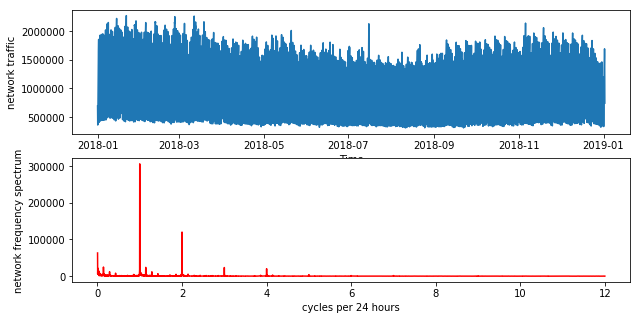

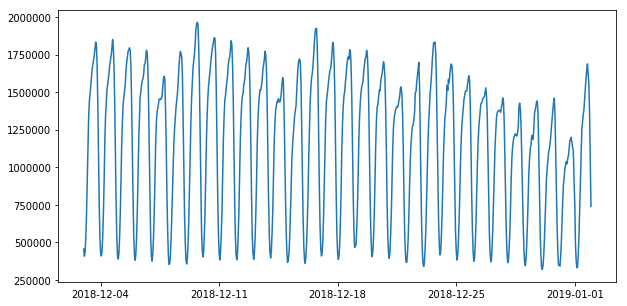

In [19]:
ts = time_series_wiki[583]
discrete_ft(ts,day)
plt.figure(figsize = (10,5))
plt.plot(ts[-month:])

## Now we look at a few examples of Trend time series:
Trend = non-periodic time dependence

In [20]:
# check a few Trend time series
df.loc[df['character'] == 'trend', :].sort_values(by = 'trend_score', ascending = False).head()

,project,trend_score,hday_score,day_score,week_score,month_score,character,mean,std
746,uz.wiktionary.org,36.158317,6.646503,11.745983,0.000000,0.000000,trend,202.448770,175.684755
666,sv.wikiversity.org,34.920641,8.780989,17.403121,7.213818,0.000000,trend,50.443989,43.352579
773,www.wikidata.org,34.574029,0.000000,17.765845,6.123458,6.355391,trend,64895.940574,32640.506107
514,nostalgia.wikipedia.org,31.236253,0.000000,7.099546,0.000000,0.000000,trend,23.196380,54.190756
422,ln.wikipedia.org,30.654178,0.000000,0.000000,0.000000,4.258209,trend,373.752618,730.446066


This example shows trendy behavior (reflected as peak near zero freq component in the frequency spectrum). It also has some day-seasonality but dominant characteristic is trend.

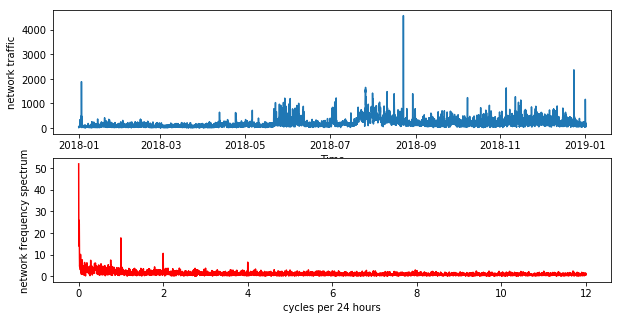

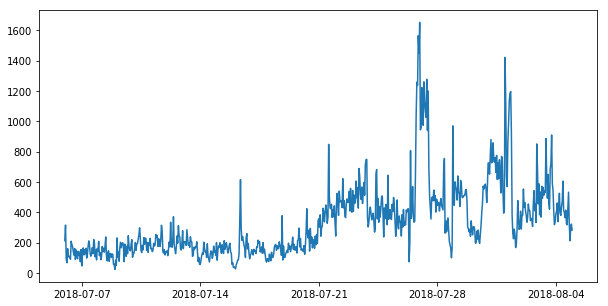

In [21]:
ts = time_series_wiki[746]
discrete_ft(ts,day)
plt.figure(figsize = (10,5))
plt.plot(ts[-6*month:-5*month])

## A special subcategory of day-seasonality that needs to be taken care separately.

This Day-impulse type of time series are more like periodic daily impulse trains. These time series are not easy to predict with current deepAR model.

In [22]:
# check a few DayImpulse time series
df.loc[df['character'] == 'DayImpulse', :].head()

,project,trend_score,hday_score,day_score,week_score,month_score,character,mean,std
2,aa.wiktionary.org,9.347850,11.925226,11.978428,0.0,0.000000,DayImpulse,5.751138,15.827372
4,ab.wiktionary.org,8.253239,15.463952,14.215497,0.0,4.614637,DayImpulse,6.962887,20.878857
8,af.wikibooks.org,7.731113,15.861358,17.465511,0.0,0.000000,DayImpulse,8.364185,13.974948
10,af.wikiquote.org,8.900630,13.191388,17.494777,0.0,0.000000,DayImpulse,11.170537,16.165619
17,am.wikiquote.org,5.981971,19.206338,17.578217,0.0,0.000000,DayImpulse,7.442168,19.795553


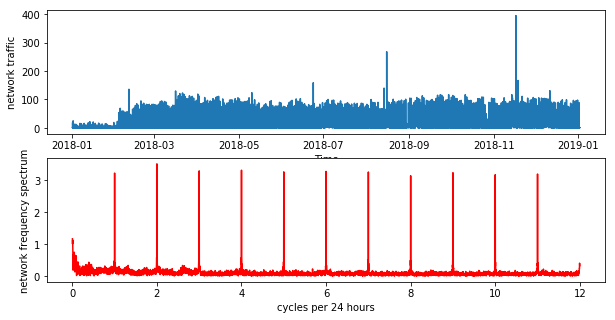

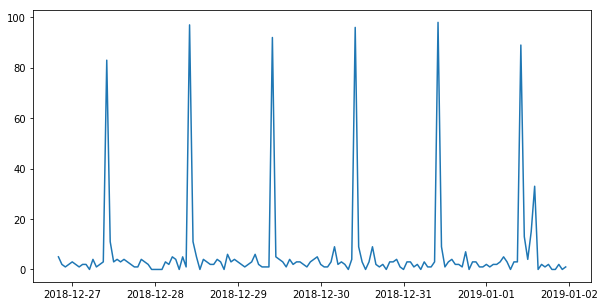

In [23]:
# DayImpulse example
ts = time_series_wiki[17]
discrete_ft(ts,day)
plt.figure(figsize = (10,5))
plt.plot(ts[-week:])

## *Spike*: the time series that doesn't show strong seasonality or trend.
In frequency domain, we won't find any signature peaks.

In [24]:
# check a few spiky time series
df.loc[df['character'] == 'spike', :].head()

,project,trend_score,hday_score,day_score,week_score,month_score,character,mean,std
16,am.wiktionary.org,0.0,0.0,0.0,0.0,0.0,spike,21.171676,311.631902
445,mhr.wikipedia.org,0.0,0.0,0.0,0.0,0.0,spike,255.601434,584.741952


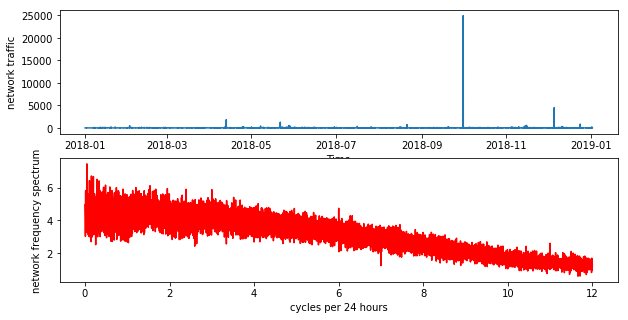

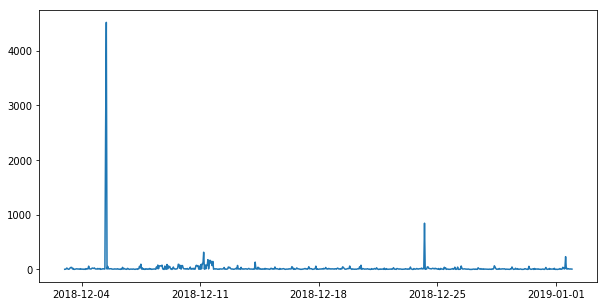

In [25]:
# a spike example: doesn't show any trend or seansonality, no distinctive peaks in freq domain
ts = time_series_wiki[16]
discrete_ft(ts,day)
plt.figure(figsize = (10,5))
plt.plot(ts[-month:])